<font size = 8 >**OBJETIVOS** </font>


1.   Processar os dados
2.   Selecionar os melhores modelos preditivos
3.   Interpretar resultados

**A fazer**
- XGB e RF
-  combinação de modelos
- Comparar importância de atributos dct com lr
- avaliar modelos finais


# Configuração do ambiente

* Instala os pacotes necessários
* Importa as bibliotecas
* Define os objetos que serão utilizados para validação cruzada
* Define funções para exibir o resumo estatístico da validação cruzada

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [2]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.9 MB/s eta 0:00:00


In [4]:
from IPython.display import HTML
def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [46]:
import optuna
import dtreeviz
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
from xgboost import XGBClassifier as XGB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from  sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.metrics import  roc_auc_score, accuracy_score , balanced_accuracy_score , average_precision_score, recall_score ,precision_score , make_scorer
from sklearn.compose import  ColumnTransformer
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution
from optuna.distributions import IntDistribution
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm

In [6]:
dados = pd.read_csv('https://raw.githubusercontent.com/Gabrieldpll/Hotel-Reservations/main/Hotel_Reservations_feature_engineering%20.csv')

In [7]:
dados['required_car_parking_space'] = dados['required_car_parking_space'].astype('bool')
dados['repeated_guest'] = dados['repeated_guest'].astype('bool')
dados['feriado'] = dados['feriado'].astype('bool')
dados['data'] = pd.to_datetime(dados['data'])

In [8]:
y = dados['booking_status'].map({'Canceled' : 0 ,'Not_Canceled' : 1})
X = dados.drop('booking_status',axis = 1)

In [9]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True,random_state = 13)
cv_inner  = StratifiedKFold(n_splits=3)


In [10]:
train_index ,test_index = list(skf.split(X,y))[0]
y_test_fold_01 , X_test_fold_01 = y.iloc[test_index] , X.iloc[test_index]
y_train_fold_01 , X_train_fold_01 = y.iloc[train_index] , X.iloc[train_index]

In [11]:
def report(score):
  dicionario = dict()
  for name, key in score.items():
    if name == 'estimator':
       dicionario['hyperparameter'] = [key[i].best_params_ for i in range(10)]
    else:
      dicionario[str(name)] = f"{round(key.mean(),4)} ({round(key.std(),4)})"
  return dicionario


In [12]:
sns.set_style("whitegrid")

In [13]:
import plotly.express as px

# Processamento dos dados

* Nessa seção o objeto é criar Pipeline para o pré-processamento dos dados.

In [14]:
(X.columns)

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'is_duplicated',
       'duplicated_count', 'data', 'Trimestre', 'feriado'],
      dtype='object')

In [15]:
# Vamos dividir os atributos para o pré-processamento


numerical_continuos = ['avg_price_per_room','lead_time']
numerical_discrete = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights','duplicated_count', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']

categorical_nominal = [ 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved','market_segment_type', 'repeated_guest','is_duplicated','Trimestre','feriado','arrival_year','arrival_month']



In [16]:
X.filter(numerical_discrete, axis = 1).agg(['mean','std']).T.assign(cv = lambda x : x['std']/x['mean'])

,mean,std,cv
no_of_adults,1.890000,0.528702,0.279737
no_of_children,0.141231,0.462502,3.274797
no_of_weekend_nights,0.882385,0.887371,1.005651
no_of_week_nights,2.261923,1.512341,0.668609
duplicated_count,0.395192,2.685184,6.794627
no_of_previous_cancellations,0.028538,0.408891,14.327723
no_of_previous_bookings_not_canceled,0.213115,2.068243,9.704806
no_of_special_requests,0.741962,0.815109,1.098587


In [17]:
X.filter(numerical_continuos, axis = 1).agg(['mean','std']).T.assign(cv = lambda x : x['std']/x['mean'])

,mean,std,cv
avg_price_per_room,105.695838,37.876592,0.358355
lead_time,66.452846,68.606799,1.032413


* Atributos categóricos serão codificados por meio do one hot encoding. O atributo "dia da reserva" foi removido para evitar um aumento desnecessário na dimensão da matriz de atributos.
* Numéricos contínuos e discretos foram padronizados para ter média 0 e desvio padrão 1. Isso é especialmente importante para evitar problemas numéricos nos otimizadores da regressão logística com penalização e para evitar problemas em algumas distâncias utilizadas no KNN.
* Nas duas tabelas acima, temos noção da diferença de escala entre as variáveis numéricas, o que serve como justificativa para o procedimento de normalização. Contudo, esse procedimento pode dificultar a interpertação futuras, que terá de ser feita considerando a normalização


In [18]:
t = [('num', StandardScaler(), numerical_continuos),
     ('dicrete', StandardScaler(), numerical_discrete),
    ('cat',OneHotEncoder( sparse_output = False ,handle_unknown = 'infrequent_if_exist' ),categorical_nominal)]
col_transform = ColumnTransformer(transformers=t, remainder = 'drop')


In [19]:
col_transform

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['avg_price_per_room', 'lead_time']),
                                ('dicrete', StandardScaler(),
                                 ['no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'duplicated_count',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
                                  'no_of_special_requests']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               sparse_output=False),
                                 ['type_of_meal_plan',
                                  'required_car_parking_space',
                                  'room_type_reserved', 'market_segment_type',
                                  'repeated_guest', 'is_duplicated',
                                  'Trimestre', 'feriado', 'arrival_year',
                                  'arrival_month'])])

In [20]:
scoring_dict = {'roc_auc' : 'roc_auc',
                 'brier':  'neg_brier_score',
                 'average_precision' : 'average_precision'}

# Modelos interpretáveis

## Knn

* https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
*  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


#### Ajuste

In [194]:
knn_model =  Pipeline([
            ('preprocess', col_transform),
            ('knn', KNeighborsClassifier())
        ])

In [195]:
knn_results = cross_validate(knn_model,X,y,cv =skf, scoring = scoring_dict )


In [196]:
report(knn_results)

{'fit_time': '0.0734 (0.0217)',
 'score_time': '0.56 (0.1869)',
 'test_roc_auc': '0.8441 (0.0066)',
 'test_brier': '-0.1374 (0.0031)',
 'test_average_precision': '0.9049 (0.0045)'}

In [197]:
params = {
            "knn__n_neighbors": IntDistribution(1, 100),
            "knn__weights": CategoricalDistribution(['uniform', 'distance']),
            "knn__metric": CategoricalDistribution([ 'l1', 'l2','chebyshev','mahalanobis' ])
        }

study = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')

[I 2024-03-09 21:43:47,069] A new study created in memory with name: no-name-91229257-007e-4b7d-ae02-85663ce55cf1


In [198]:
# Realiza a busca no conjutno de validação
# Atenção demora entre 40 - 50 min

search = OptunaSearchCV(estimator =knn_model,
                        param_distributions  = params,
                        cv = cv_inner,
                        scoring='roc_auc',
                        n_jobs= -1,
                        random_state = 13,
                        refit = True,
                        study = study,
                        n_trials = 50)



<ipython-input-198-0f1ab920f194>:4: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [199]:
# Avaliamos o resultado

scores_knn = cross_validate(search, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:90: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [200]:
report(scores_knn)

{'fit_time': '475.2152 (87.8554)',
 'score_time': '9.9499 (2.1212)',
 'hyperparameter': [{'knn__n_neighbors': 44,
   'knn__weights': 'uniform',
   'knn__metric': 'l1'},
  {'knn__n_neighbors': 78, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 43, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 74, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 61, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 51, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 45, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 43, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 92, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 54, 'knn__weights': 'uniform', 'knn__metric': 'l1'}],
 'test_roc_auc': '0.8736 (0.0072)',
 'test_brier': '-0.1282 (0.0025)',
 'test_average_precision': '0.9391 (0.0038)'}

#### Análise dos resultados

In [201]:
side_by_side( pd.DataFrame.from_dict(report(knn_results), orient = 'index', columns =['resultado']),
             pd.DataFrame.from_dict(report(scores_knn), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0)

)

,resultado
fit_time,0.0734 (0.0217)
score_time,0.56 (0.1869)
test_roc_auc,0.8441 (0.0066)
test_brier,-0.1374 (0.0031)
test_average_precision,0.9049 (0.0045)
,resultado
fit_time,475.2152 (87.8554)
score_time,9.9499 (2.1212)
test_roc_auc,0.8736 (0.0072)
test_brier,-0.1282 (0.0025)


* A tabela acima mostra que a seleção de hiperparâmetros melhorou a capacidade preditiva do KNN. Isso deve-se principalmente à escolha no número de vizinhos (k). Um valor muito baixo para k cria um modelo pouco complexo, enquanto um valor alto cria um modelo mais flexível, mas pode prejudicar a generalização do modelo. A escolha da distância também é importante, no sentido de que pode contribuir para uma melhor representação da matriz de atributos. Em particular, a distância padrão do KNN implementado pela biblioteca scikit-learn é a L2 (euclidiana), enquanto a otimização de hiperparâmetros concluiu que a melhor distância é a L1.


#### Interpertação

O KNN pode ser interpretado localmente, a nível modular. Justificamos as predições exibindo os k vizinhos mais próximos de cada exemplo. Será ilustrado esse procedimento para um exemplo predito como não cancelado e um predito como cancelado





In [214]:
scores_knn['estimator'][0].best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_price_per_room',
                                                   'lead_time']),
                                                 ('dicrete', StandardScaler(),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'duplicated_count',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'is_duplicated', 'Trimestre',
                                                   'feriado', 'arrival_year',
                                                   'arrival_month'])])),
                ('knn', KNeighborsClassifier(metric='l1', n_neighbors=44))])

In [215]:
def get_kneighbors(index,modelo):
    example = X_test_fold_01.iloc[[index], :]

    X_test_standardized = modelo.named_steps['preprocess'].transform(example)

    neighbors_distances, neighbors_indices = modelo.named_steps['knn'].kneighbors(X_test_standardized)

    neighbor_data_frame = X.iloc[neighbors_indices[0], :].copy()

    return neighbor_data_frame, modelo.predict( X_test_fold_01.iloc[[index], :])


In [226]:
vizinhos_2 , predict_2 =  get_kneighbors(2,scores_knn['estimator'][0].best_estimator_)

In [227]:
vizinhos_0 , predict_0 =  get_kneighbors(0,scores_knn['estimator'][0].best_estimator_)

In [228]:
print(predict_2 , predict_0)

[0] [1]


In [231]:
(vizinhos_0['market_segment_type'].value_counts()/len(vizinhos_0))*100

Online           70.454545
Offline          22.727273
Corporate         4.545455
Complementary     2.272727
Name: market_segment_type, dtype: float64

In [232]:
vizinhos_2['market_segment_type'].value_counts()/len(vizinhos_2)*100

Online           81.818182
Offline          13.636364
Complementary     2.272727
Corporate         2.272727
Name: market_segment_type, dtype: float64

Note que há uma diferença na proporção de vizinhos que são da classe "online". Os vizinhos mais próximos do exemplo que foi predito como cancelado (vizinho_2) têm 10% a mais de exemplos da classe "online".


In [233]:
vizinhos_0['lead_time'].describe()

count     44.000000
mean      74.977273
std       71.023576
min        0.000000
25%       19.000000
50%       45.500000
75%      114.500000
max      247.000000
Name: lead_time, dtype: float64

In [234]:
vizinhos_2['lead_time'].describe()

count     44.000000
mean      69.272727
std       79.408676
min        0.000000
25%       16.500000
50%       49.000000
75%       79.250000
max      386.000000
Name: lead_time, dtype: float64

Note que a mediana do tempo de espera dos vizinhos mais próximos do exemplo que cancelou é maior.




## Regressão logistica

### Ajuste

In [21]:
from  sklearn.linear_model import LogisticRegression
from optuna.distributions import FloatDistribution

In [22]:
lr_model_laaso =  Pipeline([
            ('preprocess', col_transform),
            ('lr', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 13))
        ])

lr_model_ridge =  Pipeline([
            ('preprocess', col_transform),
            ('lr', LogisticRegression(penalty = 'l2', solver ='lbfgs', random_state = 13 ))
        ])


lr_model_elasticnet =  Pipeline([
            ('preprocess', col_transform),
            ('lr', LogisticRegression(penalty = 'elasticnet', solver = 'saga', random_state  = 13)
            )
        ])

In [23]:
paramslr_regresion = {'lr__C' : FloatDistribution(1e-10, 1000 ,log = True)}
paramslr_regresion_elastic = {'lr__C' : FloatDistribution(1e-10, 1000 ,log = True),
                              'lr__l1_ratio' :  FloatDistribution(0, 1)}

In [24]:
study_lr_model_laaso = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')
study_lr_model_ridge = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')
study_lr_model_elasticnet = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')

[I 2024-03-09 18:07:38,378] A new study created in memory with name: no-name-da65188a-4caf-4e06-8504-1a3d59d3eb41
[I 2024-03-09 18:07:38,381] A new study created in memory with name: no-name-508639e5-36d6-4673-a23d-829c581b5b5f
[I 2024-03-09 18:07:38,387] A new study created in memory with name: no-name-1392cc7d-7beb-4bb1-addb-e0f9ef105b79


In [25]:
search_lr_model_laaso = OptunaSearchCV(estimator =lr_model_laaso,
                        param_distributions  = paramslr_regresion,
                        cv = cv_inner,
                        scoring='roc_auc',
                        n_jobs= -1,
                        random_state = 13,
                        refit = True,
                        study = study_lr_model_laaso,
                        n_trials = 50)



<ipython-input-25-a49f667a25bd>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [256]:
search_lr_model_ridge = OptunaSearchCV(estimator =lr_model_ridge,
                        param_distributions  = paramslr_regresion,
                        cv = cv_inner,
                        scoring='roc_auc',
                        n_jobs= -1,
                        random_state = 13,
                        refit = True,
                        study = study_lr_model_ridge,
                        n_trials = 50)


<ipython-input-256-320a16bff9cf>:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [257]:
searchlr_model_elasticnet = OptunaSearchCV(estimator =lr_model_elasticnet,
                            param_distributions  = paramslr_regresion_elastic,
                            cv = cv_inner,
                            scoring='roc_auc',
                            n_jobs= -1,
                            random_state = 13,
                            refit = True,
                            study = study_lr_model_elasticnet,
                            n_trials = 50)


<ipython-input-257-abde3cd492ef>:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [26]:
scores_lr_model_laaso= cross_validate(search_lr_model_laaso, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:90: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [254]:
report(scores_lr_model_laaso)

{'fit_time': '192.8169 (15.6467)',
 'score_time': '0.1272 (0.1143)',
 'hyperparameter': [{'lr__C': 0.7052287283980041},
  {'lr__C': 0.8103089410427883},
  {'lr__C': 0.8191335224810549},
  {'lr__C': 0.9974762927745836},
  {'lr__C': 0.6770887055427328},
  {'lr__C': 0.9110525614305315},
  {'lr__C': 0.627385809979982},
  {'lr__C': 0.42556110511016876},
  {'lr__C': 0.894991091025032},
  {'lr__C': 0.8801974722492041}],
 'test_roc_auc': '0.8655 (0.0068)',
 'test_brier': '-0.1303 (0.0025)',
 'test_average_precision': '0.9404 (0.0042)'}

In [258]:
scores_lr_model_ridge   = cross_validate(search_lr_model_ridge, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:90: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [259]:
report(scores_lr_model_ridge)

{'fit_time': '61.5144 (4.9662)',
 'score_time': '0.0868 (0.0472)',
 'hyperparameter': [{'lr__C': 0.5136448959492269},
  {'lr__C': 141.66597349347026},
  {'lr__C': 2.1240255217508106},
  {'lr__C': 78.89215239145622},
  {'lr__C': 839.685317312511},
  {'lr__C': 855.708845933887},
  {'lr__C': 0.5426556335575673},
  {'lr__C': 793.5652939025861},
  {'lr__C': 531.9936150818475},
  {'lr__C': 30.77930496713029}],
 'test_roc_auc': '0.8655 (0.0068)',
 'test_brier': '-0.1302 (0.0024)',
 'test_average_precision': '0.9404 (0.0041)'}

In [260]:
scores_lr_model_elasticnet = cross_validate(searchlr_model_elasticnet, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:90: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [261]:
report(scores_lr_model_elasticnet)

{'fit_time': '385.4667 (9.5106)',
 'score_time': '0.0468 (0.0165)',
 'hyperparameter': [{'lr__C': 0.097021097718064,
   'lr__l1_ratio': 0.9985419201816359},
  {'lr__C': 0.902068727157638, 'lr__l1_ratio': 0.5249336006795103},
  {'lr__C': 0.07328983926061666, 'lr__l1_ratio': 0.983669362748972},
  {'lr__C': 0.28230970816239537, 'lr__l1_ratio': 0.01297174867017703},
  {'lr__C': 0.44544988886339565, 'lr__l1_ratio': 0.08289446528669117},
  {'lr__C': 0.11942361400362339, 'lr__l1_ratio': 0.9730480825175244},
  {'lr__C': 0.11020734135497472, 'lr__l1_ratio': 0.6804980312713083},
  {'lr__C': 0.11843534195315425, 'lr__l1_ratio': 0.7431310709268792},
  {'lr__C': 0.07461065612753302, 'lr__l1_ratio': 0.9966935533124082},
  {'lr__C': 0.4383850866931545, 'lr__l1_ratio': 0.042739178768339325}],
 'test_roc_auc': '0.8652 (0.0069)',
 'test_brier': '-0.1303 (0.0025)',
 'test_average_precision': '0.9401 (0.0043)'}

### Análise dos resultados

In [ ]:
side_by_side( pd.DataFrame.from_dict(report(scores_lr_model_laaso), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),
             pd.DataFrame.from_dict(report(scores_lr_model_ridge), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),
            pd.DataFrame.from_dict(report(scores_lr_model_elasticnet), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),



)

,resultado
fit_time,190.3225 (15.6251)
score_time,0.0534 (0.0201)
test_roc_auc,0.8655 (0.0068)
test_brier,-0.1303 (0.0025)
test_average_precision,0.9404 (0.0042)
,resultado
fit_time,60.0282 (4.1765)
score_time,0.0535 (0.0166)
test_roc_auc,0.8655 (0.0068)
test_brier,-0.1302 (0.0025)


* O tempo para o ajuste do modelo com penalização Ridge foi menor quando comparado aos demais, já o tempo para a penalização ElasticNet foi o maior de todos, sendo, em média, cinco vezes maior que o da penalização Ridge. Isso deve ser analisado com cuidado, devido à escolha de otimizadores diferentes para cada penalização.

* Considerando os modelos com as três penalizações diferentes, não há diferença expressiva entre as métricas (Brier, ROC_AUC e Average Precision).

* Futuramente, pode-se considerar métricas como AIC e BIC para "seleção estatística" dos modelos. Essas métricas ajudam a selecionar um modelo parcimonioso e poderiam ser utilizadas para justificar a escolha de um dos três modelos.


### Interpertação dos resultados

#### Coeficientes

comentar diagnostico , intervalo de confiança e modelos reduzidos

In [27]:
def sort_by_abs(x):
  sorted_index = x.abs().sort_values(ascending=False).index
  x = x[sorted_index]
  return x

In [28]:
def limpar_feature_names(x):
  posicao = x.find('__') + 2
  string_nova = x[posicao:]
  return string_nova



In [29]:
def get_coef_from_dict(score_dict,fold):
  '''
  Input : Dicionário gerado pela função cross_validate() , posição do fold
  Output : Série com os coeficientes da regressão
  '''
  feature_names =   score_dict['estimator'][fold].best_estimator_.named_steps['preprocess'].get_feature_names_out()
  feature_names = [limpar_feature_names(feature_names[i]) for i in range(len(feature_names))]
  coef = score_dict['estimator'][fold].best_estimator_.named_steps['lr'].coef_
  return pd.Series(data = coef[0] , index = feature_names)

In [30]:
def get_coef_from_PipeLine(pipeline):
  feature_names =   pipeline.named_steps['preprocess'].get_feature_names_out()
  feature_names = [limpar_feature_names(feature_names[i]) for i in range(len(feature_names))]
  coef = pipeline.named_steps['lr'].coef_
  return pd.Series(data = coef[0] , index = feature_names)


In [31]:
coef_laaso = get_coef_from_dict(scores_lr_model_laaso,0)
print(f"Foram selecionados {np.sum(coef_laaso != 0)} dos {len(coef_laaso)} atributos")

Foram selecionados 38 dos 50 atributos


In [88]:
# para facilitar iremos organizar a lista dos coeficientes em ordem decrescente
coeficientes_selecionados = coef_laaso[coef_laaso != 0]
coeficientes_selecionados = sort_by_abs(coeficientes_selecionados)

In [33]:
print(coeficientes_selecionados[0:5])




market_segment_type_Complementary    2.808285
arrival_month_1                      2.303145
market_segment_type_Offline          2.160702
repeated_guest_True                  1.887264
required_car_parking_space_True      1.538442
dtype: float64


In [34]:
data_frame_coef = pd.DataFrame(index = coeficientes_selecionados.index , data = coeficientes_selecionados.values, columns= ['coeficiente'] )
data_frame_coef['positivo'] = data_frame_coef['coeficiente'] > 0
fig = px.bar(data_frame_coef, x = 'coeficiente' , y = data_frame_coef.index, orientation='h', color = 'positivo')
fig.show()

https://www.smartpricing.it/en/blog/complementary-services-hotel

* Os coeficientes da regressão logística podem ser interpretados como "uma medida de importância do atributo". Como todos os atributos foram normalizados, pode-se comparar a magnitude dos coeficientes. Um coeficiente positivo significa que aquele atributo contribuiu para aumentar a probabilidade da classe positiva (reserva não cancelada), enquanto o contrário ocorre com os coeficientes negativos.


**Sobre os cofientes da regressão é possível fazer as seguintes observações** :

**Alternativamente, podemos considerar a razão de chances**.Primeiramente, para um determinado indivíduo, a chance é dada por:

$  \frac{p_i}{1 - p_i} = \frac{\frac{1}{1 + \exp(-\eta_1)}}{1 - \frac{1}{1 + \exp(-\eta_1)}} = \exp(\eta_1)
 $

\\

Considere dois exemplos com preditores lineares $\eta_{1}$
e $\eta_{2}$ , logo a razão de chances é dada por $OR = \frac{C_1}{C_2}$ = $exp(\eta_1 - \eta_2)$

\\
Suponha que o interesse seja avaliar a razão de chances para um atributo \(X_k\) contínuo. Considere que todos os outros atributos sejam mantidos constantes, e que a diferença entre os preditores lineares seja devido ao acréscimo de uma unidade no atributo \(X_k\). Reescrevemos a razão de chances como:

$ OR = \frac{\exp(X^t\beta_0 \times (X_k + 1)\beta_k \times X_{k+1}\beta_{k+1} \dots)}{\exp(X^t\beta_0 \times (X_k)\beta_k \times X_{k+1}\beta_{k+1} \dots)} = \exp\left(\frac{(X_k + 1) \times \beta_k}{X_k \times \beta_k}\right) = \exp(\beta_k) $

Reescrevemos e obtemos $C_1 = C_2 \times \exp(\beta_k)$. Ou seja, o acréscimo de 1 unidade em uma variável contínua corresponde à multiplicação da chance por $\exp(\beta_k)$.

\\
Suponha que o interesse seja avaliar a razão de chances para um atributo categórico em um esquema de one hot encoding, em que uma categoria de \(k\) níveis é codificada em \(k\) colunas de 0 e 1. Considere que todos os atributos sejam mantidos constantes e a diferença nos preditores lineares seja apenas devida à presença de um dos \(k\) níveis, considerando que o primeiro preditor tem presente o nível 1 e o seguinte o nível 2. Nesse caso, devido ao procedimento de one hot encoding, cada nível terá um coeficiente. Chamaremos $\beta_{k1}$ o coeficiente da estimação do primeiro nível e $\beta_{k2}$ o do segundo.

\\

Por argumentos semelhantes ao do caso contínuo, podemos reescrever (lembrando que as categorias são codificadas em variáveis indicadoras que zeram parte do preditor linear)


$ OR = \exp\left(\frac{\mathbb{1}(\text{{nivel1}}) \times \beta_{k1}}{\mathbb{1}(\text{{nivel2}}) \times \beta_{k2}}\right) $

Então,
$C_1 = C_2 \times  \exp\left(\frac{\mathbb{1}(\text{{nivel1}}) \times \beta_{k1}}{\mathbb{1}(\text{{nivel2}}) \times \beta_{k2}}\right)$


O que é ligeiramente diferente da interpretação em que uma variável de referência é tomada (isso é, one hot encoding considerando k-1 níveis para cada categoria.

\\

Por fim, um estimador pontual é obtido substituindo os coeficientes estimados, e um estimador intervalar pode ser obtido via método delta.


In [ ]:
# Contínuos

In [251]:
# Categoricos

#### Resíduos, possíveis outilers e suposições

http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/

**A seguir, é feita uma breve nota sobre algumas das suposições do modelo logístico:**

* A variável resposta deve ser binária e independente. Isso é satisfeito em nosso problema com a remoção das observações duplicadas durante a etapa de análise exploratória. Essa é a suposição mais importante; se for violada, outros modelos que levem em conta erros correlacionados devem ser considerados.

* Linearidade entre as variáveis preditoras e a resposta predita (na escala logit). Pode ser verificada em um gráfico de pontos com curva ajustada. Caso essa suposição seja violada, recomenda-se utilizar modelos mais flexíveis, como modelos semi-paramétricos ou modelos aditivos.

* Poucas observações influentes/outliers. Para verificar essa suposição, deve ser conduzida uma análise de influência e de resíduos. A violação dessa suposição pode impactar nas estimativas dos coeficientes e em seus erros padrões.


Uma análise de resíduos será conduzida utilizando os resíduos Randomized Quantile Residual. Mais informações sobre esse resíduo podem ser encontradas  [nesse artigo](https://www.jstor.org/stable/1390802). Não iremos entrar em detalhes nesse trabalho, pois essa discussão desvia dos objetivos específicos deste estudo.


In [35]:
# vetor de probabilidades predita (necessário para os resíduos)
prob_vector = scores_lr_model_laaso['estimator'][0].best_estimator_.predict_proba(X_train_fold_01)[:,1]

In [37]:
# Implementação dos resíduos (veja o artigo)
def sample_riq(y,mu):
  if y == 0:
    residuo = np.random.uniform(low = 0  , high = 1 - mu)
  else:
    residuo = np.random.uniform(low = 1  - mu, high = 1 )
  return residuo

def r_iq(y,mu):
  residuos = [norm.ppf(sample_riq(y[i] , mu[i])) for i in range(len(mu))]
  return residuos

In [39]:
residuos = r_iq(y_train_fold_01.to_list(),prob_vector)

In [63]:
# https://plotly.com/python/v3/normality-test/
from scipy.stats import norm
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [41]:
# Gera um data frame dos resíduos versus tempo

residuos_data_frame = pd.DataFrame( data = list(zip(residuos,dados.filter(X_train_fold_01.index , axis = 0)['data'])),
                                   columns  = ['residuo', 'data']).sort_values(by = 'data')

In [42]:
fig = px.line(residuos_data_frame , x = 'data', y = 'residuo' )
fig.show()

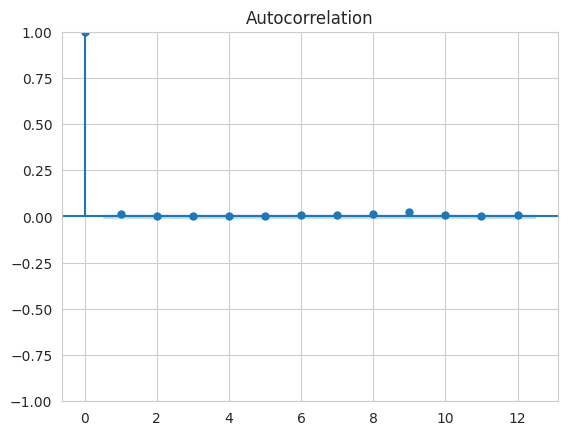

In [47]:
sm.graphics.tsa.plot_acf(residuos_data_frame['residuo'], lags = 12)
plt.show()

In [48]:
print(sm.tsa.stattools.kpss(residuos_data_frame['residuo']))

(0.16843365569767543, 0.1, 28, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


<ipython-input-48-b058792d26d5>:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




https://en.wikipedia.org/wiki/KPSS_test   \\
https://www.statisticshowto.com/kpss-test/

* Como pode ser visto pelos gráficos e pelo teste estatístico, nota-se que não há evidências de autocorrelação nos resíduos. Caso houvesse, teríamos que considerar alguma forma de capturar essa estrutura temporal.



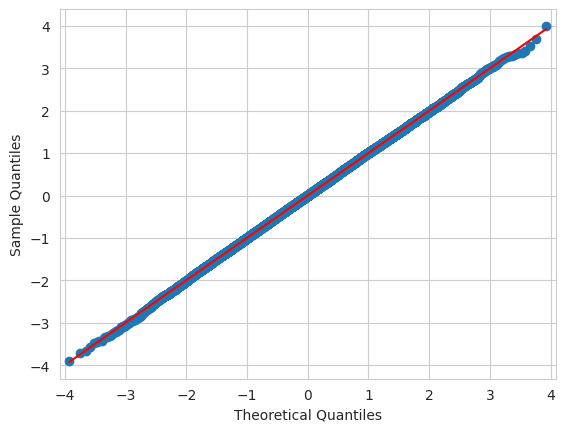

In [49]:
#https://plotly.com/python/v3/normality-test/
import statsmodels.api as sm
qqplot_data = sm.qqplot(np.array(residuos), line='s').gca().lines



O Gráfico informa que algumas observações desviam da linha de referência (vermelha). No entanto, não sabemos como identificar tais pontos, vamos propor uma versão interativa  desse gráfico.

In [50]:
# Necessário identificar as observações.
# Revisar, pode haver um modo mais simples.

identificar_residuos = pd.DataFrame(data = list(zip(residuos,X_train_fold_01.index)), columns = ['residuo', 'index']).sort_values(by = 'residuo')

In [51]:
identificar_residuos.head(5)

,residuo,index
16636,-3.911301,18495
9019,-3.713878,10024
22625,-3.658230,25131
13100,-3.571640,14537
15561,-3.469776,17304


In [52]:

fig = go.Figure()

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data[0].get_xdata(),
    'y': qqplot_data[0].get_ydata(),
    'mode': 'markers',
    'text': identificar_residuos['index'].values,

    'marker': {
        'color': '#19d3f3'
    }
})

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data[1].get_xdata(),
    'y': qqplot_data[1].get_ydata(),
    'mode': 'lines',

    'line': {
        'color': '#636efa'
    }

})


fig['layout'].update({
    'title': 'Quantile-Quantile Plot',
    'xaxis': {
        'title': 'Theoritical Quantities',
        'zeroline': False
    },
    'yaxis': {
        'title': 'Sample Quantities'
    },
    'showlegend': False,
    'width': 800,
    'height': 700,
})

fig.show()

In [53]:
dados.filter([ 11573, 22523,  16917, 11774],axis = 0)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,is_duplicated,duplicated_count,data,Trimestre,feriado
11573,2,0,1,2,Meal Plan 1,False,Room_Type 6,69,2018,1,...,0,0,82.00,0,Not_Canceled,False,0,2018-01-29,primeiro_trimestre,False
22523,2,0,1,3,Meal Plan 1,False,Room_Type 1,122,2018,4,...,0,0,60.59,0,Not_Canceled,False,0,2018-04-18,terceiro_trimestre,False
16917,2,0,2,1,Meal Plan 1,False,Room_Type 1,271,2018,12,...,0,0,62.64,0,Not_Canceled,False,0,2018-12-03,quarto_trimestre,False
11774,2,0,0,1,Not Selected,False,Room_Type 1,4,2018,2,...,0,0,81.00,0,Not_Canceled,False,0,2018-02-06,primeiro_trimestre,False


Os resíduos, supondo um modelo adequado, seguem uma distribuição normal padrão(veja artigo mencionado).Utilizamos o qqplot para verificar se há resíduos que desviam da sua distribuição teórica. Note que os pontos estão, em geral, alinhados, indicando que não há muitos desvios da distribuição normal padrão. É útil dar "zoom" nas caudas do gráfico, geralmente onde têm-se resíduos discrepantes. Para fins de ilustração, selecionamos 4 observações que desconfiamos de ter resíduo discrepante e iremos reajustar o modelo para verificar se essas observações influenciam nos coeficientes/predições. Alternativamente, um envelope simulado pode ser programado, baseado em um esquema bootstrap, e podemos estudar os pontos fora desse envelope.


In [54]:
report(scores_lr_model_laaso)['hyperparameter'][0]

{'lr__C': 0.7052287283980041}

In [74]:
modelo_alternativo =  Pipeline([
            ('preprocess', col_transform),
            ('lr', LogisticRegression(penalty = 'l1',C = 0.7052287283980041  ,solver = 'liblinear', random_state = 13))
        ])

In [75]:
X_train_fold_01_filtrado = X_train_fold_01.drop([ 11573, 22523,  16917, 11774], axis  = 0)
y_tain_fold_01_filtrado = y_train_fold_01.drop([ 11573, 22523,  16917, 11774], axis  = 0)

In [76]:
modelo_alternativo.fit(X_train_fold_01_filtrado,y_tain_fold_01_filtrado)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_price_per_room',
                                                   'lead_time']),
                                                 ('dicrete', StandardScaler(),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'duplicated_count',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'is_duplicated', 'Trimestre',
                                                   'feriado', 'arrival_year',
                                                   'arrival_month'])])),
                ('lr',
                 LogisticRegression(C=0.7052287283980041, penalty='l1',
                                    random_state=13, solver='liblinear'))])

In [106]:
coef_modelo_alternativo = get_coef_from_PipeLine(modelo_alternativo)
coeficientes_modelo_alternativo = coef_modelo_alternativo[coef_modelo_alternativo != 0]
coeficientes_modelo_alternativo  = sort_by_abs(coeficientes_modelo_alternativo)
print(f"Foram selecionados {np.sum(coef_modelo_alternativo != 0)} dos {len(coef_modelo_alternativo)} atributos")

Foram selecionados 38 dos 50 atributos


In [96]:
# chat gpt
def elementos_diferentes(lista1, lista2):
    set1 = set(lista1)
    set2 = set(lista2)
    diferenca = set1.symmetric_difference(set2)
    return list(diferenca)


In [109]:
coeficientes_selecionados[-5:]

type_of_meal_plan_Not Selected   -0.029130
arrival_month_9                  -0.020925
feriado_False                     0.004019
no_of_adults                     -0.002775
arrival_month_10                  0.000021
dtype: float64

In [110]:
coeficientes_modelo_alternativo[-5:]

type_of_meal_plan_Not Selected   -0.021423
arrival_month_9                  -0.020745
feriado_False                     0.003470
no_of_adults                     -0.002999
arrival_month_7                   0.000085
dtype: float64

In [97]:
elementos_diferentes(coeficientes_selecionados.index,coeficientes_modelo_alternativo.index)

['arrival_month_7', 'arrival_month_10']

* Note que não houve muita diferença entre os coeficientes, exceto que o atributo "arrival month 10" não foi considerado no modelo alternativo, enquanto o atributo "arrival month 7" foi incluído. Mesmo assim, ambos foram considerados com coeficientes muito pequenos.


In [61]:
y_pred_laaso_fold_01 = scores_lr_model_laaso['estimator'][0].best_estimator_.predict_proba(X_test_fold_01)[:,1]

y_pred_laaso_alternativo_01 = modelo_alternativo.predict_proba(X_test_fold_01)[:,1]

In [62]:
print(f"A diferença máxima entre as duas predições é de {np.max(y_pred_laaso_fold_01 - y_pred_laaso_alternativo_01)}\n"
      f"Erro médio quadrático é {np.sqrt(np.mean((y_pred_laaso_fold_01 - y_pred_laaso_alternativo_01) ** 2))}\n"
      f"O erro absoluto médio é {np.mean(np.abs(y_pred_laaso_fold_01 - y_pred_laaso_alternativo_01))}")

A diferença máxima entre as duas predições é de 0.002063410233865859
Erro médio quadrático é 0.00031553145247906385
O erro absoluto médio é 0.00020220989452394435


* Note que a remoção das observações também não impacta na predição


**Vamos verificar a suposição de linearidade**

Adaptado de :  http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/

In [145]:
def get_transformed_df_from_pipeline(pipe,X):
  feature_names =   pipe.named_steps['preprocess'].get_feature_names_out()
  transformed =  pipe.named_steps['preprocess'].transform(X)
  df_transformed = pd.DataFrame(data= transformed, columns = feature_names)
  return df_transformed

In [148]:
transformed_matrix_fold_01 = get_transformed_df_from_pipeline(scores_lr_model_laaso['estimator'][0].best_estimator_, X_train_fold_01)

In [149]:
from scipy.special import logit


In [150]:
transformed_matrix_fold_01['logit']  = logit(prob_vector)

In [191]:
def plot_check_linearity(var_alvo):
    fig = sns.regplot(data=transformed_matrix_fold_01, x='logit', y=var_alvo, ci=0.95,
                     scatter_kws={'alpha': 0.25, 'color': 'grey'}, line_kws={'color': 'blue'}, lowess=True)

    fig.set_title(f"Relação entre logit e {var_alvo}")
    fig.set_xlabel('logit')
    fig.set_ylabel(var_alvo)

    # Exibindo o gráfico
    plt.show()


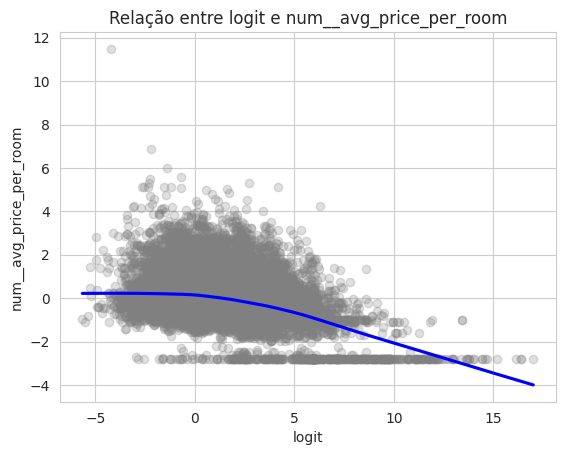

In [190]:
plot_check_linearity('num__avg_price_per_room')

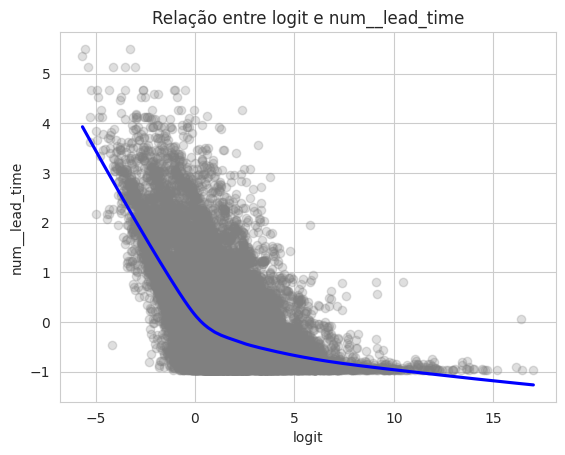

In [187]:
plot_check_linearity('num__lead_time')

* Podemos suspeitar da linearidade dos dois preditores numéricos contínuos. Um próximo passo seria considerar uma extensão do modelo logístico modelando esses preditores via splines, por exemplo.


#### Estimativa intervalar

Referências sobre a estimativa intervalar (do ponto de vista frequentista) e pós-inferência em modelos com penalização podem ser encontradas em:

* [Post-Selection Inference](https://www.annualreviews.org/doi/10.1146/annurev-statistics-100421-044639)
* [Statistical Learning with Sparsity](https://hastie.su.domains/StatLearnSparsity/), em especial no capítulo 6.

Alternativamente, pode-se considerar modelos bayesianos com shrinkage priors, em que a quantificação de incerteza é natural utilizando simulações MCMC da distribuição a posteriori.
\\

Nesse trabalho, para não desviar o foco, não abordaremos a estimativa intervalar. Embora esse estudo possa ser interessante em análises futuras.


#### Hyperparâmetros

In [292]:
report(scores_lr_model_laaso)['hyperparameter']

[{'lr__C': 0.7052287283980041},
 {'lr__C': 0.8103089410427883},
 {'lr__C': 0.8191335224810549},
 {'lr__C': 0.9974762927745836},
 {'lr__C': 0.6770887055427328},
 {'lr__C': 0.9110525614305315},
 {'lr__C': 0.627385809979982},
 {'lr__C': 0.42556110511016876},
 {'lr__C': 0.894991091025032},
 {'lr__C': 0.8801974722492041}]

In [294]:
report(scores_lr_model_ridge)['hyperparameter']

[{'lr__C': 0.5136448959492269},
 {'lr__C': 141.66597349347026},
 {'lr__C': 2.1240255217508106},
 {'lr__C': 78.89215239145622},
 {'lr__C': 839.685317312511},
 {'lr__C': 855.708845933887},
 {'lr__C': 0.5426556335575673},
 {'lr__C': 793.5652939025861},
 {'lr__C': 531.9936150818475},
 {'lr__C': 30.77930496713029}]

In [296]:
report(scores_lr_model_elasticnet)['hyperparameter']

[{'lr__C': 0.097021097718064, 'lr__l1_ratio': 0.9985419201816359},
 {'lr__C': 0.902068727157638, 'lr__l1_ratio': 0.5249336006795103},
 {'lr__C': 0.07328983926061666, 'lr__l1_ratio': 0.983669362748972},
 {'lr__C': 0.28230970816239537, 'lr__l1_ratio': 0.01297174867017703},
 {'lr__C': 0.44544988886339565, 'lr__l1_ratio': 0.08289446528669117},
 {'lr__C': 0.11942361400362339, 'lr__l1_ratio': 0.9730480825175244},
 {'lr__C': 0.11020734135497472, 'lr__l1_ratio': 0.6804980312713083},
 {'lr__C': 0.11843534195315425, 'lr__l1_ratio': 0.7431310709268792},
 {'lr__C': 0.07461065612753302, 'lr__l1_ratio': 0.9966935533124082},
 {'lr__C': 0.4383850866931545, 'lr__l1_ratio': 0.042739178768339325}]

## Modelos Baseados em árvores

* Foi ajustado um modelo de árvore de decisão
* OS hiperparâmetros foram ajustados para obter uma árvore de decisão com maior capacidade preditiva
* Foram indicadas formas de interpretar os resultados


### Ajuste

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_dct =  Pipeline([
            ('preprocess', col_transform),
            ('dct', DecisionTreeClassifier(random_state = 13))
        ])

In [ ]:
# Esse comando ajusta uma árvore de decisão com os hiperparâmetros padrão.

dct_results = cross_validate(model_dct,X,y,cv =skf, scoring = scoring_dict )


In [ ]:
report(dct_results)

{'fit_time': '0.1666 (0.0066)',
 'score_time': '0.0108 (0.0004)',
 'test_roc_auc': '0.767 (0.0057)',
 'test_brier': '-0.1959 (0.0049)',
 'test_average_precision': '0.8468 (0.0035)'}

In [ ]:




params_dct = {
            "dct__max_depth": IntDistribution(1, 30),
            "dct__criterion": CategoricalDistribution(['gini', 'entropy', 'log_loss']),
            "dct__min_samples_split": FloatDistribution(0,1,log = False),
            "dct__min_samples_leaf": FloatDistribution(0,1,log = False),
            "dct__max_features": CategoricalDistribution(['sqrt', 'log2'])

        }

 Os hiperparâmetros serão otimizados considerando o espaço de busca descrito por params_dct. Os hiperparâmetros têm os seguintes significados:
- **max_depth:** Profundidade máxima da árvore. Quanto maior a profundidade, maior a complexidade do modelo. Deve ser ajustado de maneira parcimoniosa, evitando modelos simples (underfitting) e modelos complexos (overfitting).
- **criterion:** É uma função utilizada para decidir se um nó será dividido.
- **min_samples_split:** É o número de exemplos necessários para dividir um nó. Serve para evitar nós puros e pode reduzir a influência de outliers.
- **min_samples_leaf:** É o número de exemplos necessários para formar um nó terminal. Serve para evitar nós puros e pode reduzir a influência de outliers.


In [ ]:
study_dct = optuna.create_study(sampler=TPESampler(seed=13), pruner=HyperbandPruner(), direction='maximize')


[I 2024-03-07 18:03:57,850] A new study created in memory with name: no-name-4704500c-5bd2-4afd-95b0-aa7136b5cdbc


In [ ]:
search_dct = OptunaSearchCV(estimator=model_dct,
                            param_distributions=params_dct,
                            cv=cv_inner,
                            scoring='roc_auc',
                            n_jobs=-1,
                            random_state=13,
                            refit=True,
                            n_trials=300,
                            study=study_dct)

<ipython-input-139-09b0e9c801e6>:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [ ]:
scores_dct = cross_validate(search_dct, X, y, scoring=scoring_dict, cv=skf, n_jobs=-1, return_train_score=False, return_estimator=True)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:90: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



### Análise dos resultados

In [ ]:
#
side_by_side( pd.DataFrame.from_dict(report(dct_results), orient = 'index', columns =['resultado']),
             pd.DataFrame.from_dict(report(scores_dct), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),

)

,resultado
fit_time,0.1666 (0.0066)
score_time,0.0108 (0.0004)
test_roc_auc,0.767 (0.0057)
test_brier,-0.1959 (0.0049)
test_average_precision,0.8468 (0.0035)
,resultado
fit_time,78.2223 (5.5091)
score_time,0.0159 (0.0026)
test_roc_auc,0.8676 (0.009)
test_brier,-0.1254 (0.0048)


Note que o procedimento de seleção de hiperparâmetros melhorou significativamente o desempenho do modelo. Isso pode ser atribuído principalmente à escolha cuidadosa do hiperparâmetro `max_depth`, que possibilita a aprendizagem de modelos mais parcimoniosos, evitando assim o overfitting.


In [ ]:
pd.DataFrame(report(scores_dct)['hyperparameter'])

,dct__max_depth,dct__criterion,dct__min_samples_split,dct__min_samples_leaf,dct__max_features
0,26,entropy,0.011763,0.000059,log2
1,17,log_loss,0.080508,0.000342,sqrt
2,29,log_loss,0.001100,0.001204,log2
3,24,entropy,0.014239,0.000401,sqrt
4,14,gini,0.017898,0.000365,log2
5,11,log_loss,0.013576,0.002778,sqrt
6,22,log_loss,0.019527,0.000157,log2
7,21,entropy,0.000438,0.001402,log2
8,14,entropy,0.000622,0.000720,log2
9,28,entropy,0.003304,0.000777,sqrt


O DataFrame acima exibe os melhores hiperparâmetros para cada fold. Note que o critério Gini foi utilizado apenas uma vez. Além disso, observa-se que o hiperparâmetro `dct__min_samples_leaf` geralmente apresentou valores abaixo das 3 casas decimais. Os demais hiperparâmetros não exibem padrões evidentes.

  



### Interpertação

Os modelos baseados em árvores são considerados interpretáveis, pois para justificar suas previsões, basta seguir o caminho do nó terminal até o nó raiz. Um gráfico da estrutura da árvore pode ser utitilizado para interpretação dos resultados. No entanto, em árvores profundas, esse gráfico pode se tornar ilegível. Para contornar esse hiato, medidas de importância de atributos podem ser empregadas. Essas medidas quantificam a contribuição global de cada atributo para as previsões.

In [ ]:
def plot_tree(score_dict,index):
  '''
    Recebe: Um dicionário contendo os resultados do procedimento de validação cruzada e um índice indicando o fold a ser considerado.
    Retorna:
    - dtreeviz.model (para visualizar a árvore)
    - Matriz de atributos do conjunto de teste transformado (para justificar predições futuramente)
    - Vetor resposta do conjunto de teste
    - DataFrame com a importância das features
'''



  # Utilizando o dicionário de scores recuperamos o modelo e os nomes dos atributos
  arvore = scores_dct['estimator'][index].best_estimator_.named_steps['dct']
  feature_names = scores_dct['estimator'][index].best_estimator_.named_steps['preprocess'].get_feature_names_out()
  feature_names = [limpar_feature_names(i) for i in feature_names]

  # Criamos um dataframe de feature importance, ordenando pela maior contribuição
  FI = arvore.feature_importances_
  data_frame_fi = pd.DataFrame(data = FI , index = feature_names, columns = ['feature_importance']).sort_values(by = 'feature_importance', ascending  = False)



  # Recupera os dados utilizados para o treino e teste do modelo
  train_index ,test_index = list(skf.split(X,y))[index]
  y_tain_fold , X_train_fold = y.iloc[train_index] , X.iloc[train_index]
  y_test_fold , X_test_fold = y.iloc[test_index] , X.iloc[test_index]

  # Aplicamos a transformação ao conjunto de treino e teste recuperado. Vale lembrar que esse pipeline já foi ajustado ao conjunto de treino do respectivo fold.
  # Essa etapa é essencial para a função dtreeviz.model(), que não foi projetada para considerar um pipeline.

  X_train_fold_transformed = scores_dct['estimator'][index].best_estimator_.named_steps['preprocess'].transform(X_train_fold)
  X_test_fold_transformed = scores_dct['estimator'][index].best_estimator_.named_steps['preprocess'].transform(X_test_fold)

  viz_model = dtreeviz.model(arvore,
                           X_train=X_train_fold_transformed, y_train=y_tain_fold,
                           feature_names=feature_names,
                           target_name= 'booking_status',
                          class_names= ["Canceled", "Not_Canceled"])
  return viz_model,X_test_fold_transformed,y_test_fold,data_frame_fi

In [ ]:
tree_plot,X_test,y_test, feature_importance = plot_tree(scores_dct,0)

In [ ]:
feature_importance.head(3).index

Index(['lead_time', 'no_of_special_requests', 'market_segment_type_Offline'], dtype='object')

In [ ]:
feature_importance = feature_importance.query('feature_importance > 0')


In [ ]:
 px.bar(feature_importance['feature_importance'])

O gráfico a seguir permite a visualização da importância dos atributos para a predição do modelo de árvore. **Destaca-se que as features mais relevantes incluem 'lead_time', 'no_of_special_requests' e 'market_segment_type_Offline' e avg_price_per_room**


In [ ]:
#tree_plot.view(fontname="monospace", depth_range_to_display = (0,5))

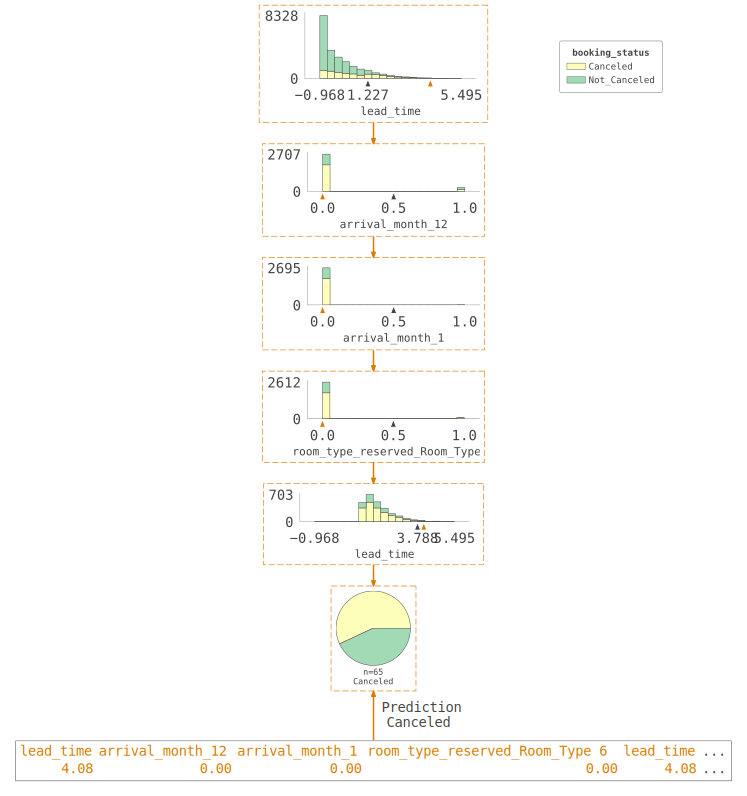

In [ ]:

tree_plot.view(x=X_test[2,:],
               show_just_path=True,
               fontname="monospace",
               label_fontsize = 12,
               ticks_fontsize = 15,
               scale  = 1.25)



Este gráfico é empregado para justificar a predição de um exemplo específico. No caso presente, o exemplo foi classificado como cancelado, principalmente devido ao elevado tempo de espera (lead_time). Na representação gráfica, é crucial observar, dentro de cada caixa que representa as partições das árvores:
- O número de observações naquela partição, no canto superior direito.
- A distribuição do atributo, condicionada ao caminho até o nó (o histograma)
- A seta preta que indica a média do conjunto geral.
- A seta amarela que indica a localização do atributo no exemplo analisado.

Ao final, há uma caixa que destaca os atributos utilizados para gerar a predição e seus respectivos valores.


In [ ]:
print(tree_plot.explain_prediction_path(x=X_test[2,:]))


3.79 <= lead_time 
room_type_reserved_Room_Type 6 < 0.5
arrival_month_1 < 0.5
arrival_month_12 < 0.5



Outra forma é imprimir o caminho da predição

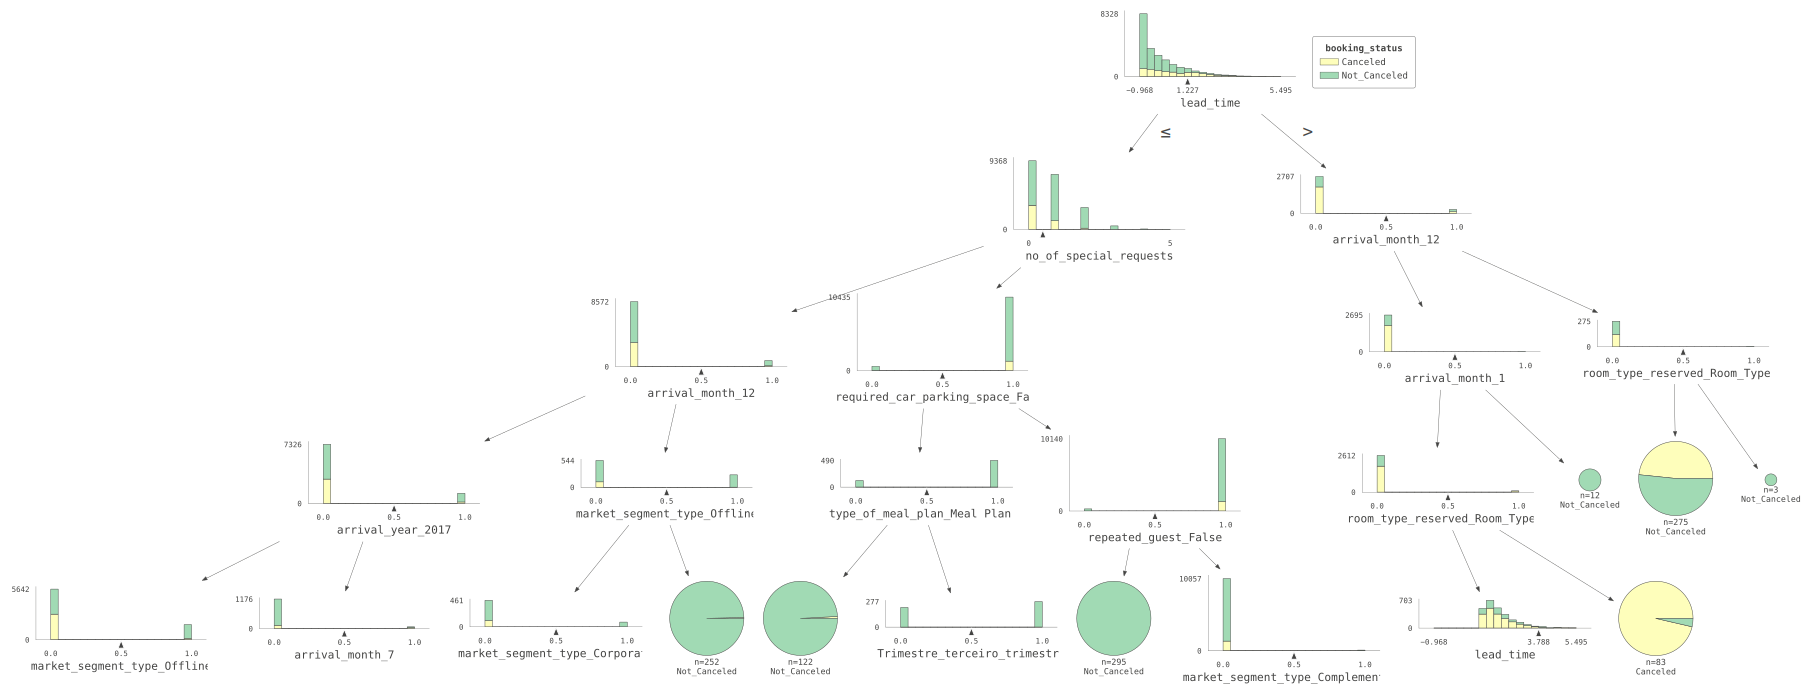

In [ ]:
tree_plot.view(
    depth_range_to_display=(0, 4), # Ajuste a profundidade em que a árvore será exibida
    fontname = "monospace",
    scale = 1.25

)

A árvore pode ser visualizada plotando-a completa ou apenas alguns de seus níveis. Dada a profundidade considerável da árvore, optamos por exibir somente os primeiros 4 níveis. Destaca-se que a primeira divisão é realizada com base no atributo 'lead_time'.


# Modelos baseados em ensembling

# SMOTE , EEN e SMOTEEEN

# Combinação de modelos




# Melhores modelos

# Interpretação de resultados